#### Imports

In [34]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

#### Import the dataset

In [35]:
circuits = pd.read_csv('./f1_dataset/circuits.csv')
constructor_results = pd.read_csv('./f1_dataset/constructor_results.csv')
constructor_standings = pd.read_csv('./f1_dataset/constructor_standings.csv')
constructors = pd.read_csv('./f1_dataset/constructors.csv')
driver_standings = pd.read_csv('./f1_dataset/driver_standings.csv')
drivers = pd.read_csv('./f1_dataset/drivers.csv')
lap_times = pd.read_csv('./f1_dataset/lap_times.csv')
pit_stops = pd.read_csv('./f1_dataset/pit_stops.csv')
qualifying = pd.read_csv('./f1_dataset/qualifying.csv')
races = pd.read_csv('./f1_dataset/races.csv')
results = pd.read_csv('./f1_dataset/results.csv')
seasons = pd.read_csv('./f1_dataset/seasons.csv')
sprint_results = pd.read_csv('./f1_dataset/sprint_results.csv')
status = pd.read_csv('./f1_dataset/status.csv')

#### Basic dataset statistics

In [36]:
basic_info = pd.DataFrame()
for file in os.listdir('f1_dataset'):
    df = pd.read_csv(os.path.join('f1_dataset', file))
    new_info = pd.DataFrame({
        'File': [file],
        'Samples': [len(df)],
        'Columns': [len(df.columns)]
    })
    basic_info = pd.concat([basic_info, new_info], axis=0, ignore_index=True)

display(basic_info)

,File,Samples,Columns
0,circuits.csv,77,9
1,constructors.csv,212,5
2,constructor_results.csv,12505,5
3,constructor_standings.csv,13271,7
4,drivers.csv,859,9
5,driver_standings.csv,34595,7
6,lap_times.csv,575029,6
7,pit_stops.csv,10990,7
8,qualifying.csv,10254,9
9,races.csv,1125,18


#### For what years do we have lap times, pit stop times?

In [38]:
lap_times_races = pd.merge(lap_times, races, left_on='raceId', right_on='raceId')
print(', '.join(map(str, sorted(lap_times_races["year"].unique()))))

1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024


#### Merge couple of datasets

In [15]:
a = results[["raceId", "driverId", "statusId"]]
b = drivers[["driverId", "forename", "surname"]]
c = status[["statusId", "status"]]
d = races[['raceId', 'year']]

In [16]:
merged_ab = pd.merge(a, b, on="driverId")
merged_abc = pd.merge(merged_ab, c, on="statusId")
merged_abcd = pd.merge(merged_abc, d, on='raceId')

In [17]:
merged_abcd

,raceId,driverId,statusId,forename,surname,status,year
0,18,1,1,Lewis,Hamilton,Finished,2008
1,18,2,1,Nick,Heidfeld,Finished,2008
2,18,3,1,Nico,Rosberg,Finished,2008
3,18,4,1,Fernando,Alonso,Finished,2008
4,18,5,1,Heikki,Kovalainen,Finished,2008
...,...,...,...,...,...,...,...
26514,1116,1,2,Lewis,Hamilton,Disqualified,2023
26515,1116,844,2,Charles,Leclerc,Disqualified,2023
26516,1116,839,130,Esteban,Ocon,Collision damage,2023
26517,1116,4,140,Fernando,Alonso,Undertray,2023


In [18]:
status_counts = merged_abc['status'].value_counts()[:20]

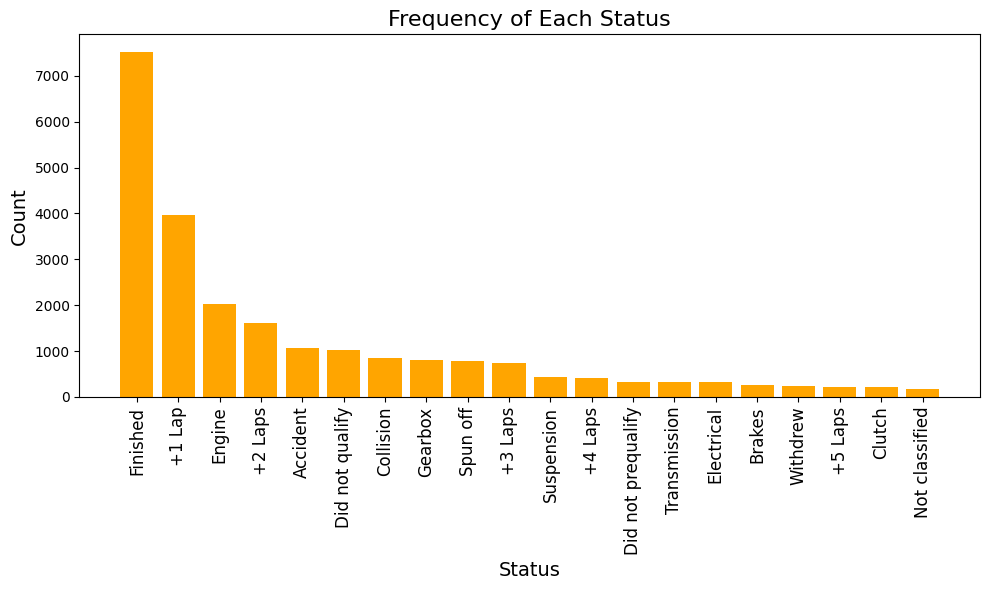

In [19]:
plt.figure(figsize=(10, 6))
plt.bar(status_counts.index, status_counts.values, color='orange')
plt.xticks(rotation=90, fontsize=12)
plt.title('Frequency of Each Status', fontsize=16)
plt.xlabel('Status', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.tight_layout()  # Adjust layout to avoid label overlap
plt.show()

### Further Analysis

In [20]:
year_threshold = 2014

##### Filter the races

In [21]:
filtered_data = merged_abcd[merged_abcd['year'] > year_threshold]
finished_races = filtered_data[filtered_data['status'] == 'Finished']

#### Drivers with the most race finishes?

In [22]:
race_finishes = finished_races.groupby('driverId').size().reset_index(name='finishes')
race_finishes = race_finishes.merge(b, on='driverId')
race_finishes = race_finishes.sort_values(by='finishes', ascending=False)

display(race_finishes.head(10))

,driverId,finishes,forename,surname
0,1,184,Lewis,Hamilton
18,830,158,Max,Verstappen
14,822,137,Valtteri,Bottas
11,815,125,Sergio,Pérez
7,20,116,Sebastian,Vettel
20,832,112,Carlos,Sainz
12,817,109,Daniel,Ricciardo
30,844,96,Charles,Leclerc
32,846,82,Lando,Norris
3,8,80,Kimi,Räikkönen


#### Drivers with the most incidents per race ratio:

In [23]:
incident_statuses = ['Accident', 'Retired', 'Collision']
incidents = filtered_data[filtered_data['status'].isin(incident_statuses)]

# Calculate total races and incidents per driver
total_races = filtered_data.groupby('driverId').size().reset_index(name='total_races')
total_incidents = incidents.groupby('driverId').size().reset_index(name='total_incidents')

# Merge and calculate ratio
incident_ratio = pd.merge(total_races, total_incidents, on='driverId', how='left').fillna(0)
incident_ratio['incident_per_race'] = incident_ratio['total_incidents'] / incident_ratio['total_races']
incident_ratio = incident_ratio.merge(b, on='driverId')
incident_ratio = incident_ratio.sort_values(by='incident_per_race', ascending=False)

display(incident_ratio.head(20))

,driverId,total_races,total_incidents,incident_per_race,forename,surname
10,813,19,5.0,0.263158,Pastor,Maldonado
48,858,33,6.0,0.181818,Logan,Sargeant
46,856,11,2.0,0.181818,Nyck,de Vries
14,821,21,3.0,0.142857,Esteban,Gutiérrez
43,853,22,3.0,0.136364,Nikita,Mazepin
18,828,81,9.0,0.111111,Marcus,Ericsson
8,154,117,13.0,0.111111,Romain,Grosjean
26,836,39,4.0,0.102564,Pascal,Wehrlein
39,849,61,6.0,0.098361,Nicholas,Latifi
9,807,141,13.0,0.092199,Nico,Hülkenberg


In [24]:
lap_data = pd.merge(lap_times, races[['raceId', 'circuitId']], on='raceId')

In [25]:
lap_data

,raceId,driverId,lap,position,time,milliseconds,circuitId
0,841,20,1,1,1:38.109,98109,1
1,841,20,2,1,1:33.006,93006,1
2,841,20,3,1,1:32.713,92713,1
3,841,20,4,1,1:32.803,92803,1
4,841,20,5,1,1:32.342,92342,1
...,...,...,...,...,...,...,...
575024,1131,858,65,19,1:10.742,70742,70
575025,1131,858,66,19,1:10.855,70855,70
575026,1131,858,67,19,1:12.454,72454,70
575027,1131,858,68,19,1:13.607,73607,70


In [26]:
circuits.head()

,circuitId,circuitRef,name,location,country,lat,lng,alt,url
0,1,albert_park,Albert Park Grand Prix Circuit,Melbourne,Australia,-37.84970,144.96800,10,http://en.wikipedia.org/wiki/Melbourne_Grand_P...
1,2,sepang,Sepang International Circuit,Kuala Lumpur,Malaysia,2.76083,101.73800,18,http://en.wikipedia.org/wiki/Sepang_Internatio...
2,3,bahrain,Bahrain International Circuit,Sakhir,Bahrain,26.03250,50.51060,7,http://en.wikipedia.org/wiki/Bahrain_Internati...
3,4,catalunya,Circuit de Barcelona-Catalunya,Montmeló,Spain,41.57000,2.26111,109,http://en.wikipedia.org/wiki/Circuit_de_Barcel...
4,5,istanbul,Istanbul Park,Istanbul,Turkey,40.95170,29.40500,130,http://en.wikipedia.org/wiki/Istanbul_Park


In [27]:
avg_lap_time = lap_data.groupby('circuitId')['milliseconds'].mean().reset_index(name='avg_lap_time')

# Merge results with status to identify incidents
incident_statuses = ['Accident', 'Retired', 'Collision']  # Define incident statuses
results_with_status = pd.merge(results, status, on='statusId')
results_with_status = pd.merge(results_with_status, races, on='raceId')

# Filter incidents and calculate incidents perr circuit
incidents = results_with_status[results_with_status['status'].isin(incident_statuses)]
incident_counts = incidents.groupby('circuitId').size().reset_index(name='incident_count')

# Total races per track
total_races = races.groupby('circuitId').size().reset_index(name='total_races')

# Merge incident counts with total races
incident_rate = pd.merge(incident_counts, total_races, on='circuitId', how='right').fillna(0)
incident_rate['incident_rate'] = incident_rate['incident_count'] / incident_rate['total_races']

# Merge avg lap time and incident rate into one dataset
track_difficulty = pd.merge(avg_lap_time, incident_rate[['circuitId', 'incident_rate']], on='circuitId')

# Normalize
scaler = MinMaxScaler()
track_difficulty[['normalized_lap_time', 'normalized_incident_rate']] = scaler.fit_transform(
    track_difficulty[['avg_lap_time', 'incident_rate']]
)

#### Add an interactive widget for defining track difficulty

In [28]:
import ipywidgets as widgets
from IPython.display import display

alpha_slider = widgets.FloatSlider(
    value=0.5,
    min=0.0,
    max=1.0,
    step=0.01,
    description='Alpha:',
    continuous_update=True
)

def update_difficulty_score(alpha):
    beta = 1 - alpha
    track_difficulty['difficulty_score'] = (
        alpha * track_difficulty['normalized_lap_time'] +
        beta * track_difficulty['normalized_incident_rate']
    )

    sorted = track_difficulty[['circuitId', 'difficulty_score']].sort_values(by='difficulty_score', ascending=False)
    td_named = pd.merge(sorted, circuits[['circuitId', 'name']], on='circuitId')
    display(td_named[['circuitId', 'name', 'difficulty_score']].head(10))

widgets.interact(update_difficulty_score, alpha=alpha_slider)


interactive(children=(FloatSlider(value=0.5, description='Alpha:', max=1.0, step=0.01), Output()), _dom_classe…

<function __main__.update_difficulty_score(alpha)>

#### Most Incident prone tracks (top 10) - table visualization

In [28]:
import pandas as pd
import tabulate

# Step 1: Merge races and circuits
# Add track names to the races table by merging it with circuits based on 'circuitId'
races_with_circuits = pd.merge(races, circuits, on='circuitId')

# Step 2: Filter results related to incidents
# Merge results with status data to include the status description for each race result
results_with_status = pd.merge(results, status, on='statusId')

# Select only the results related to incidents, such as crashes, engine failures, etc.
incident_keywords = [
    'Accident', 'Collision', 'Collision damage', 'Spun off',
    'Engine', 'Engine fire', 'Engine misfire', 'Gearbox', 'Transmission',
    'Clutch', 'Hydraulics', 'Electrical', 'Electronics', 'Brakes', 'Suspension',
    'Tyre', 'Puncture', 'Wheel', 'Wheel nut', 'Differential', 'Overheating',
    'Mechanical', 'Throttle', 'Steering', 'Driveshaft', 'Fuel pressure', 'Water pressure',
    'Refuelling', 'Oil leak', 'Fuel pump', 'Oil pressure', 'Fuel leak', 'Oil pipe',
    'Cooling system', 'Chassis', 'Battery', 'Ignition', 'Drivetrain', 'Power Unit',
    'ERS', 'Heat shield fire', 'Fire', 'Retired', 'Out of fuel', 'Vibrations',
    'Safety concerns', 'Physical', 'Illness', 'Driver unwell', 'Injured', 'Fatal accident'
]

# Filter results to include only the ones that match incident keywords
incident_results = results_with_status[
    results_with_status['status'].str.contains('|'.join(incident_keywords), case=False, na=False)
]

# Step 3: Group by circuits and count incidents
# Merge the filtered incident results with races and circuits to get the full track information
incidents_with_tracks = pd.merge(incident_results, races_with_circuits, on='raceId')

# Group the incidents by 'circuitId' and count the number of incidents for each circuit
incidents_per_circuit = incidents_with_tracks.groupby('circuitId').size().reset_index(name='incident_count')

# Merge back the track names to provide a clearer view
incidents_per_circuit = pd.merge(incidents_per_circuit, circuits[['circuitId', 'name']], on='circuitId')

# Sort the circuits by the number of incidents to identify the most incident-prone track
most_incident_prone_track = incidents_per_circuit.sort_values(by='incident_count', ascending=False).head(1)

# Display the top 10 tracks with the most incidents
top_10_incident_tracks = incidents_per_circuit.sort_values(by='incident_count', ascending=False).head(10)

# Apply formatting and styling to the DataFrame
styled_table = top_10_incident_tracks.style.format({
    'incident_count': '{:,.0f}',  # Format incident count as an integer with commas
}).background_gradient(cmap='YlGnBu', axis=None)  # Add gradient color background

# Display the styled table
styled_table


,circuitId,incident_count,name
13,14,647,Autodromo Nazionale di Monza
5,6,633,Circuit de Monaco
8,9,451,Silverstone Circuit
12,13,413,Circuit de Spa-Francorchamps
6,7,376,Circuit Gilles Villeneuve
19,20,372,Nürburgring
9,10,334,Hockenheimring
20,21,306,Autodromo Enzo e Dino Ferrari
17,18,294,Autódromo José Carlos Pace
68,70,286,Red Bull Ring


#### Top 10 Tracks with Most Incidents: A Visualization

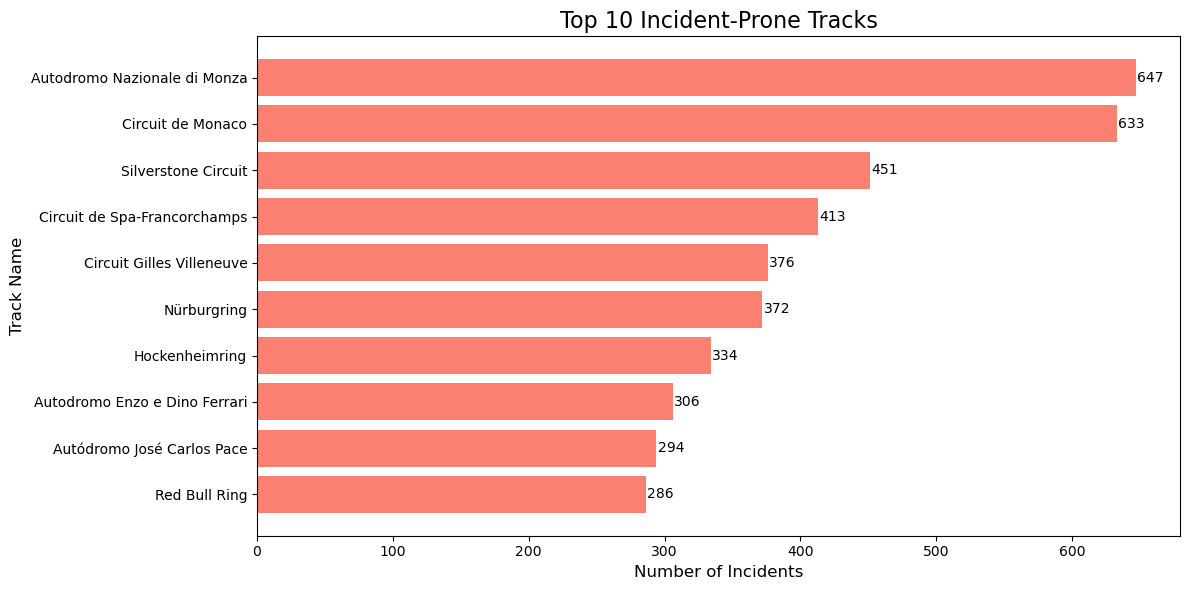

In [30]:
top_10_incident_tracks = incidents_per_circuit.sort_values(by='incident_count', ascending=False).head(10)

plt.figure(figsize=(12, 6))
plt.barh(top_10_incident_tracks['name'], top_10_incident_tracks['incident_count'], color='salmon')
plt.xlabel('Number of Incidents', fontsize=12)
plt.ylabel('Track Name', fontsize=12)
plt.title('Top 10 Incident-Prone Tracks', fontsize=16)
plt.gca().invert_yaxis()  # Obrni osi kako bi najviše incidentne staze bile na vrhu
for index, value in enumerate(top_10_incident_tracks['incident_count']):
    plt.text(value + 1, index, str(value), fontsize=10, verticalalignment='center')

plt.tight_layout()
plt.show()

#### Average lap time and pit stop time per year (here we should account for adding/removing race tracks, probably taking the last 10 years is enough)

In [32]:
# Merge races with lap times to get the year for each lap
lap_times_with_year = pd.merge(lap_times, races[['raceId', 'year']], on='raceId', how='inner')

# Filter races for the last 10 years
races_last_10_years = races[races['year'].isin(range(2015, 2025))]

# Calculate the average lap time per year (in milliseconds)
avg_lap_time_per_year = lap_times_with_year[lap_times_with_year['year'].isin(races_last_10_years['year'])]
avg_lap_time_per_year = avg_lap_time_per_year.groupby('year')['milliseconds'].mean().reset_index(name='avg_lap_time')

# Merge with pit stop data to calculate average pit stop time per year
pit_stop_with_year = pd.merge(pit_stops, races[['raceId', 'year']], on='raceId', how='inner')

# Convert 'duration' to numeric, coercing errors to NaN
pit_stop_with_year['duration'] = pd.to_numeric(pit_stop_with_year['duration'], errors='coerce')

# Calculate the average pit stop time per year
avg_pit_stop_time_per_year = pit_stop_with_year[pit_stop_with_year['year'].isin(races_last_10_years['year'])]
avg_pit_stop_time_per_year = avg_pit_stop_time_per_year.groupby('year')['duration'].mean().reset_index(name='avg_pit_stop_time')

# Merge both datasets to have average lap time and pit stop time for each year
avg_times_per_year = pd.merge(avg_lap_time_per_year, avg_pit_stop_time_per_year, on='year')

# Style the table for better visual appearance
styled_table = avg_times_per_year.style.format({
    'avg_lap_time': '{:,.2f} ms',  # Format average lap time to 2 decimal places
    'avg_pit_stop_time': '{:,.2f} ms'  # Format average pit stop time to 2 decimal places
}).background_gradient(cmap='YlGnBu', axis=None)  # Add gradient color background

# Display the styled table
styled_table


,year,avg_lap_time,avg_pit_stop_time
0,2015,"97,966.50 ms",25.27 ms
1,2016,"102,144.50 ms",24.64 ms
2,2017,"95,763.55 ms",24.24 ms
3,2018,"93,546.57 ms",24.67 ms
4,2019,"92,978.94 ms",24.87 ms
5,2020,"95,174.43 ms",25.36 ms
6,2021,"97,003.02 ms",25.01 ms
7,2022,"98,189.39 ms",24.63 ms
8,2023,"98,297.08 ms",24.75 ms
9,2024,"94,790.85 ms",24.68 ms


#### Points Margin Between Championship Winners and Runners-Up (2014-2024)

In [34]:
# Merge 'results' with 'races' to get the 'year' for each result based on the 'raceId'
results_with_year = pd.merge(results, races[['raceId', 'year']], on='raceId', how='inner')

# Group points by driver for each season and calculate the total points for each driver in each season
season_points = results_with_year.groupby(['year', 'driverId'])['points'].sum().reset_index()

# Sort the points by year and then by points (in descending order for points)
season_ranking = season_points.sort_values(by=['year', 'points'], ascending=[True, False])

# Select the top 2 drivers for each year (the first and second place drivers)
top_2_per_season = season_ranking.groupby('year').head(2)

# Calculate the points for the winner and the runner-up for each season
top_2_per_season = top_2_per_season.groupby('year').agg(
    winner_points=('points', 'max'),  # Maximum points are for the winner
    runner_up_points=('points', 'min')  # Minimum points are for the runner-up
).reset_index()

# Round the winner and runner-up points to one decimal place
top_2_per_season['winner_points'] = top_2_per_season['winner_points'].round(1)
top_2_per_season['runner_up_points'] = top_2_per_season['runner_up_points'].round(1)

# Calculate the gap in points between the winner and the runner-up
top_2_per_season['points_gap'] = top_2_per_season['winner_points'] - top_2_per_season['runner_up_points']

# Round the points gap to one decimal place for better readability
top_2_per_season['points_gap'] = top_2_per_season['points_gap'].round(1)

# Filter the results for the years between 2014 and 2024
top_2_per_season_filtered = top_2_per_season[top_2_per_season['year'].isin(range(2014, 2025))]

# Style the table for better visual appearance and format columns to 1 decimal place
styled_table = top_2_per_season_filtered.style.format({
    'winner_points': '{:,.1f}',  # Format winner points to one decimal place
    'runner_up_points': '{:,.1f}',  # Format runner-up points to one decimal place
    'points_gap': '{:,.1f}'  # Format points gap to one decimal place
}).background_gradient(cmap='YlGnBu', axis=None)  # Add gradient color background

# Display the styled table
styled_table


,year,winner_points,runner_up_points,points_gap
64,2014,384.0,317.0,67.0
65,2015,381.0,322.0,59.0
66,2016,385.0,380.0,5.0
67,2017,363.0,317.0,46.0
68,2018,408.0,320.0,88.0
69,2019,413.0,326.0,87.0
70,2020,347.0,223.0,124.0
71,2021,388.5,385.5,3.0
72,2022,433.0,291.0,142.0
73,2023,530.0,260.0,270.0


#### Average Finishing Position by Starting Grid (Position from Qualifying)

In [36]:
# Ensure 'position' is numeric, forcing errors to NaN (invalid parsing will return NaN)
results['position'] = pd.to_numeric(results['position'], errors='coerce')

# Group by grid and calculate the average finishing position
grid_summary = results.groupby('grid')['position'].mean().reset_index()

# Remove rows with NaN values in the 'position' column
grid_summary = grid_summary.dropna(subset=['position'])

# Filter out grid = 0
grid_summary_filtered = grid_summary[grid_summary['grid'] > 0]

# Sort the results by grid to see how average finishing position changes with grid position
grid_summary_sorted = grid_summary_filtered.sort_values(by='grid')

# Style the table for better visual appearance and format columns to 1 decimal place
styled_table = grid_summary_sorted.style.format({
    'position': '{:,.1f}',  # Format average finishing position to one decimal place
}).background_gradient(cmap='YlGnBu', axis=None)  # Add gradient color background

# Display the styled table
styled_table


,grid,position
1,1,2.4
2,2,3.2
3,3,3.7
4,4,4.5
5,5,5.1
6,6,5.7
7,7,6.4
8,8,7.0
9,9,7.2
10,10,7.9


<Figure size 1200x800 with 0 Axes>

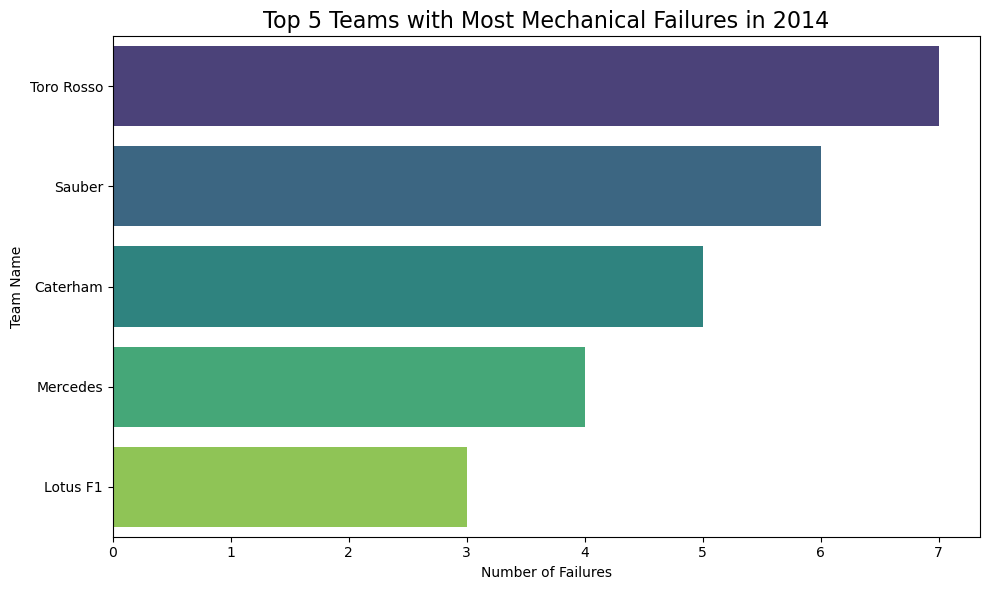

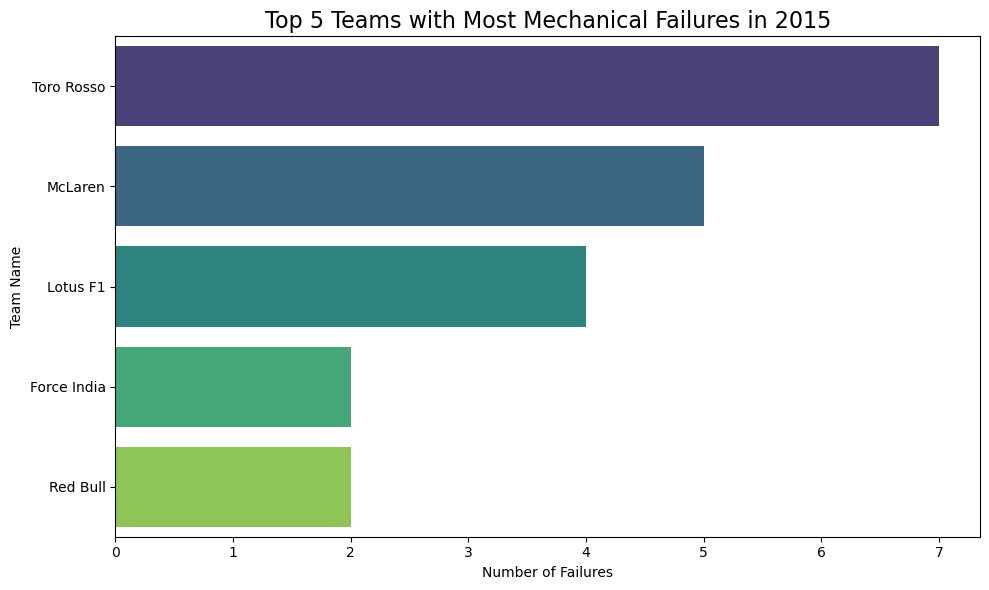

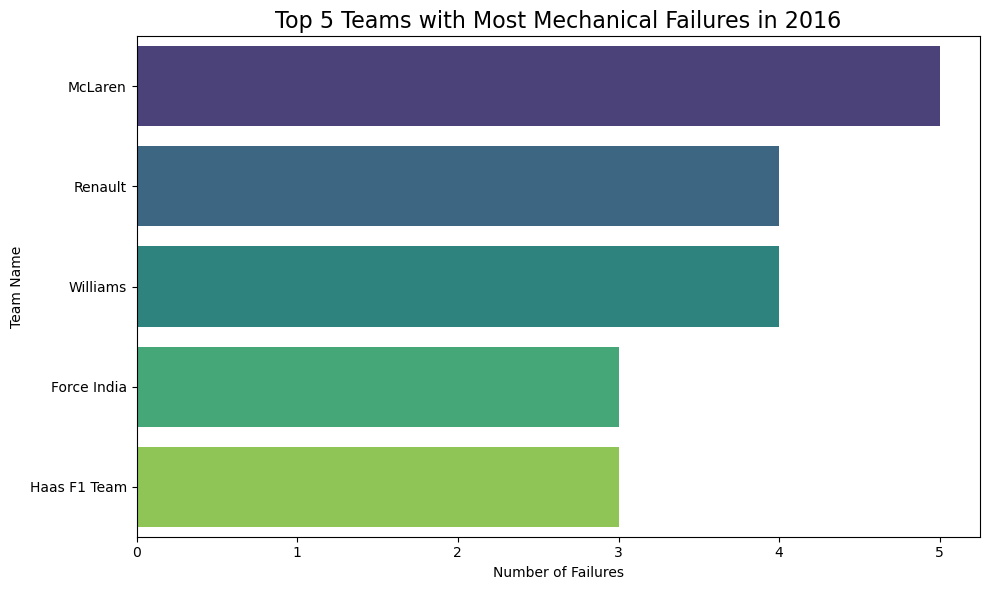

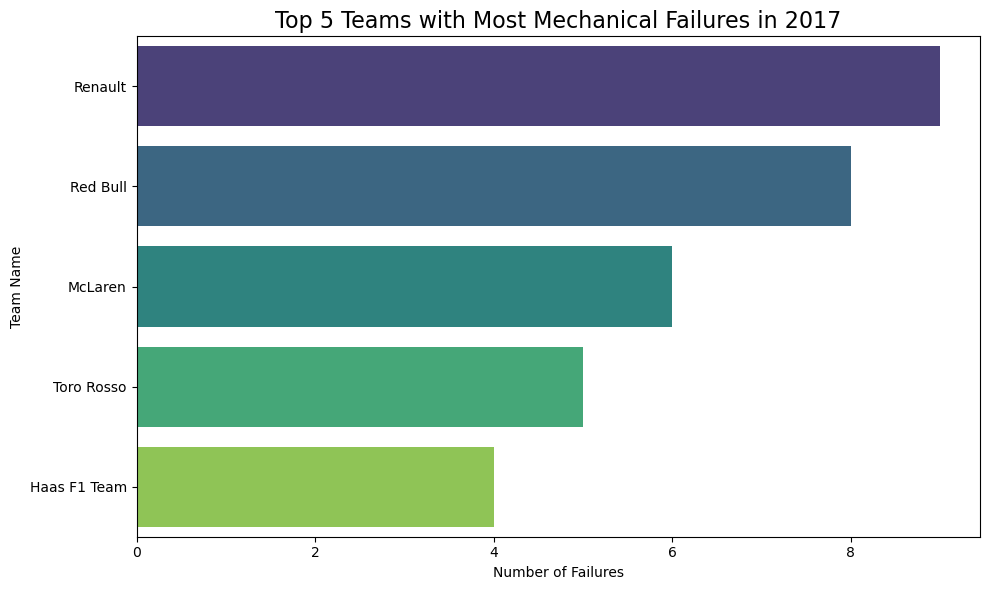

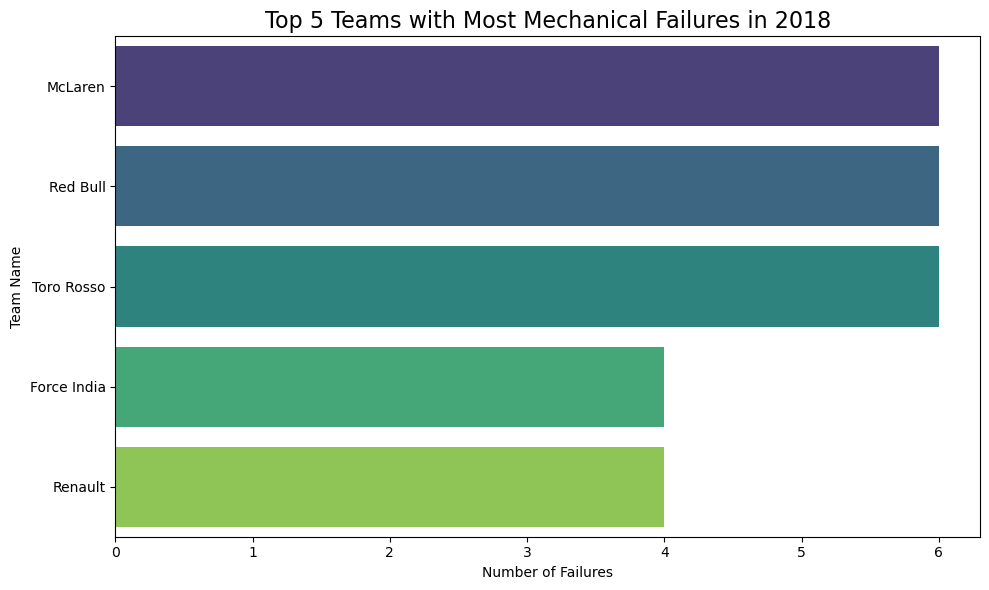

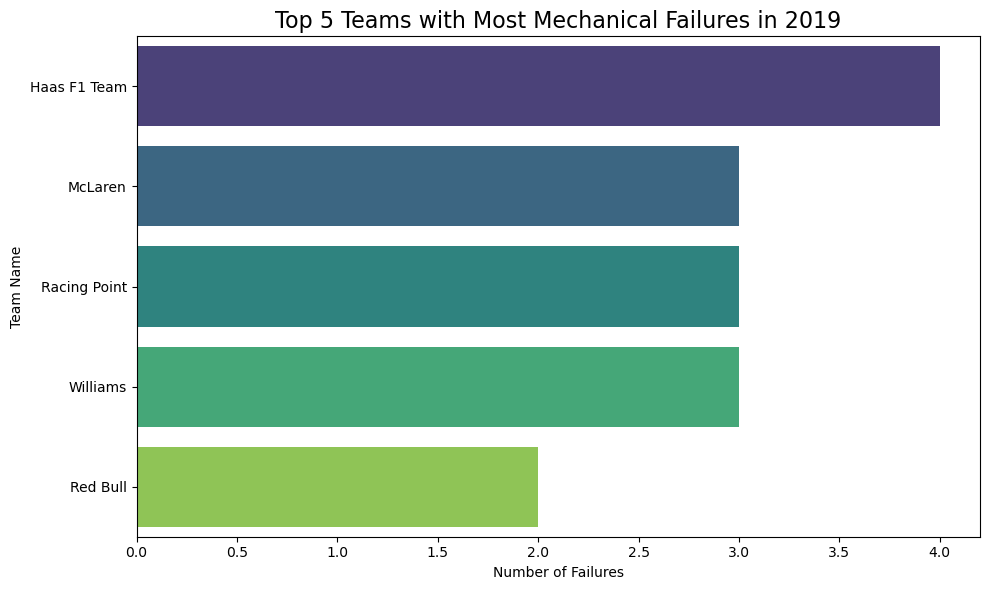

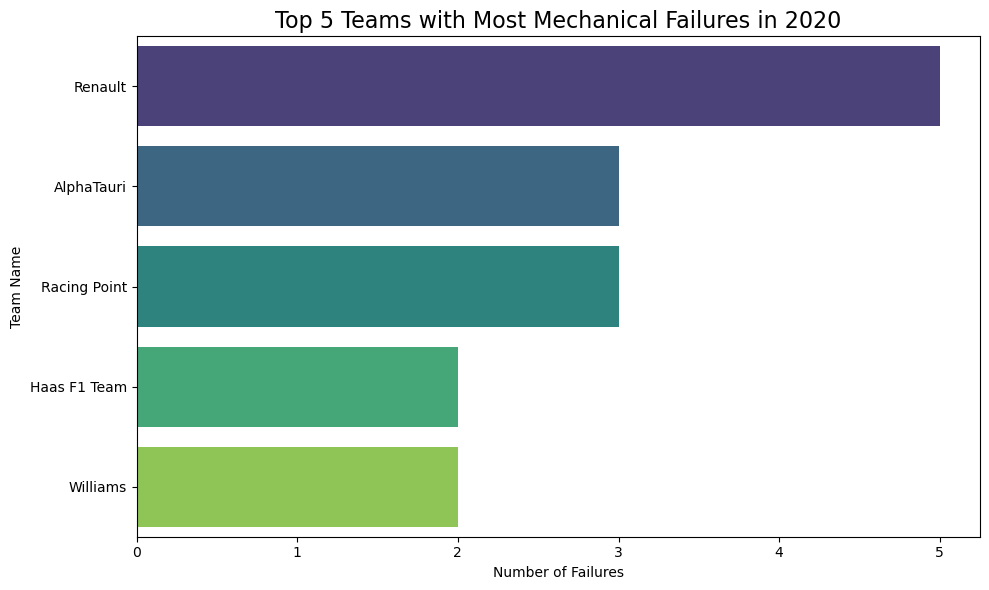

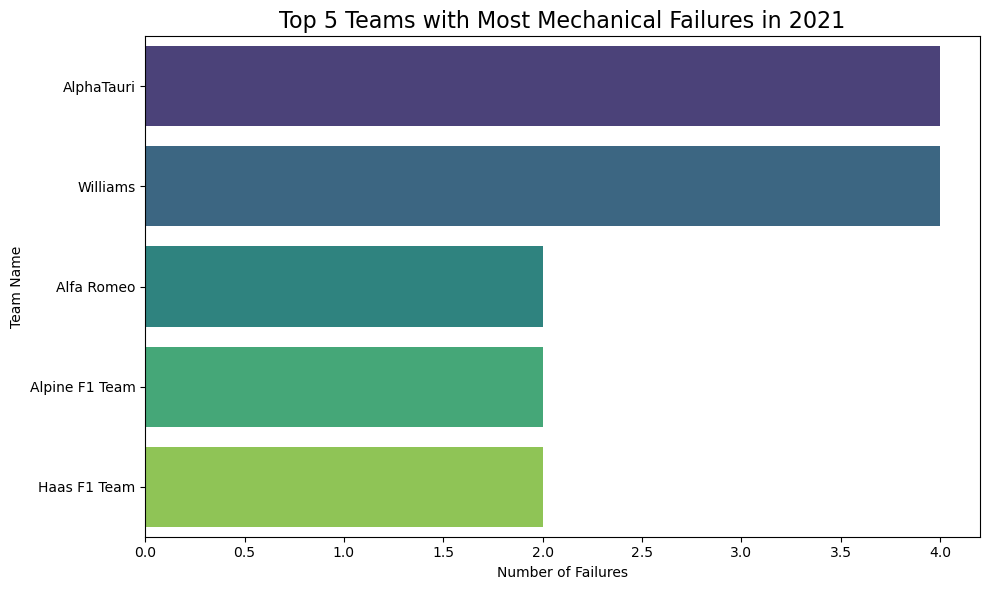

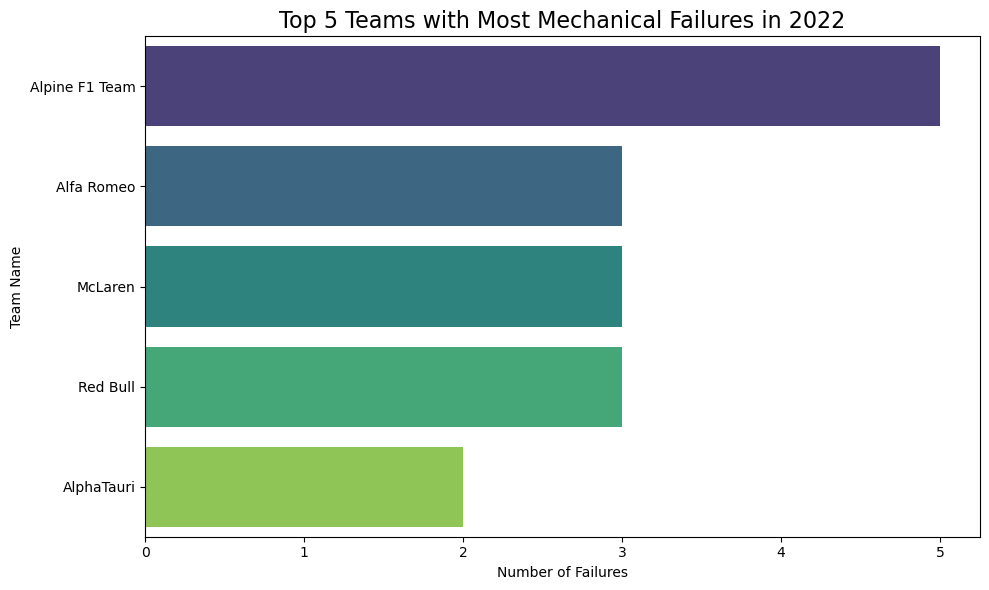

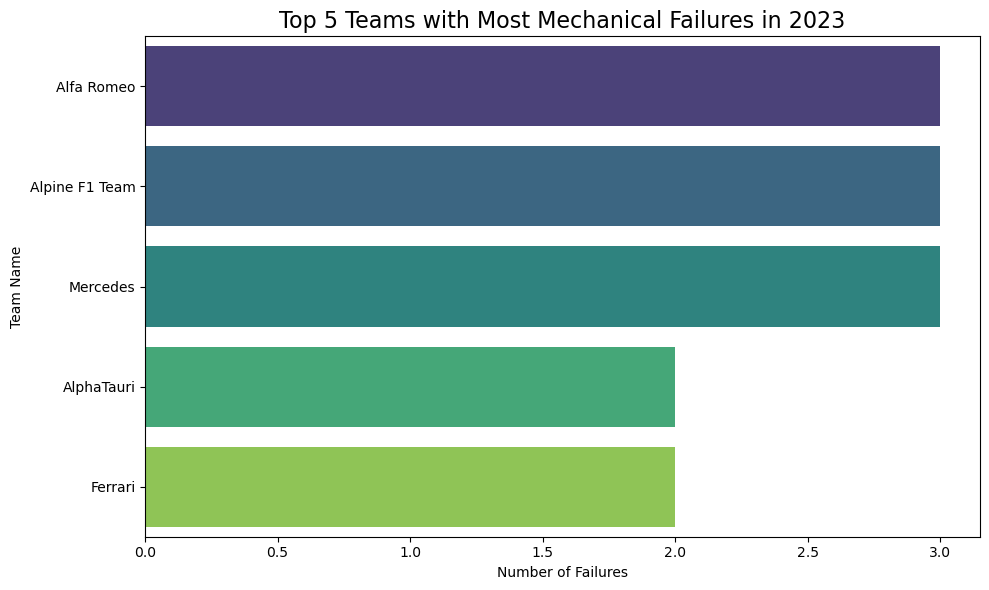

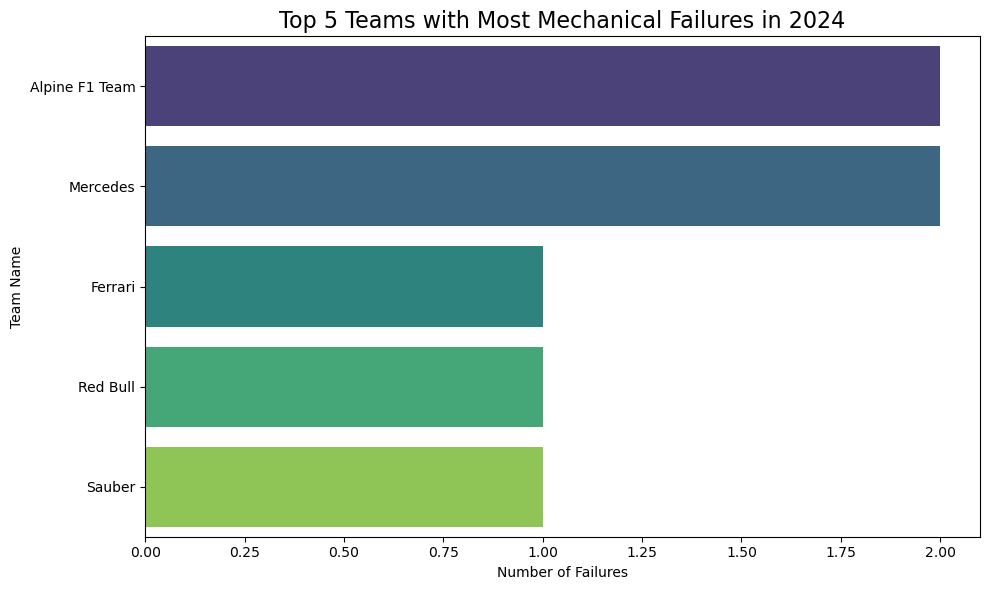

In [94]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Popis statusId koji odgovaraju mehaničkim kvarovima
mechanical_error_status_ids = [5, 6, 7, 8, 9, 10, 21, 22, 23, 24, 25, 26, 30, 32, 34, 43, 44, 51, 56, 57, 67, 79, 80, 102, 103, 109, 108, 121, 129, 133]

# 1. Filtriraj rezultate prema statusId mehaničkih kvarova
mechanical_failures = results[results['statusId'].isin(mechanical_error_status_ids)]

# 2. Spoji sa 'races' tablicom kako bi dobili datum i godinu
merged_data = pd.merge(mechanical_failures, races[['raceId', 'date']], on='raceId')

# 3. Dodaj godinu iz datuma
merged_data['year'] = pd.to_datetime(merged_data['date']).dt.year

# 4. Dodaj informacije o timu koristeći 'constructorId' i 'constructors' dataframe
merged_data = pd.merge(merged_data, constructors[['constructorId', 'name']], on='constructorId')

# 5. Grupiraj po timu i godini, te zbroji broj kvarova
failures_per_team_per_year = merged_data.groupby(['name', 'year']).size().reset_index(name='failures')

# 6. Filtriraj podatke za godine 2014-2024
failures_per_team_per_year = failures_per_team_per_year[failures_per_team_per_year['year'].between(2014, 2024)]

# 7. Kreiraj grafikon za svaku godinu
plt.figure(figsize=(12, 8))

# Sort the years array to ensure the plots are ordered chronologically
years = sorted(failures_per_team_per_year['year'].unique())

for year in years:
    # Filtriraj podatke za tu godinu
    yearly_data = failures_per_team_per_year[failures_per_team_per_year['year'] == year]
    
    # Prikazivanje top 5 timova za tu godinu
    top_5_year = yearly_data.sort_values(by='failures', ascending=False).head(5)
    
    # Kreiranje bar grafa
    plt.figure(figsize=(10, 6))
    sns.barplot(x='failures', y='name', data=top_5_year, hue='name', palette='viridis', legend=False)
    
    # Naslov
    plt.title(f"Top 5 Teams with Most Mechanical Failures in {year}", fontsize=16)
    plt.xlabel('Number of Failures')
    plt.ylabel('Team Name')
    plt.tight_layout()
    plt.show()

#### Number od DNFs per season

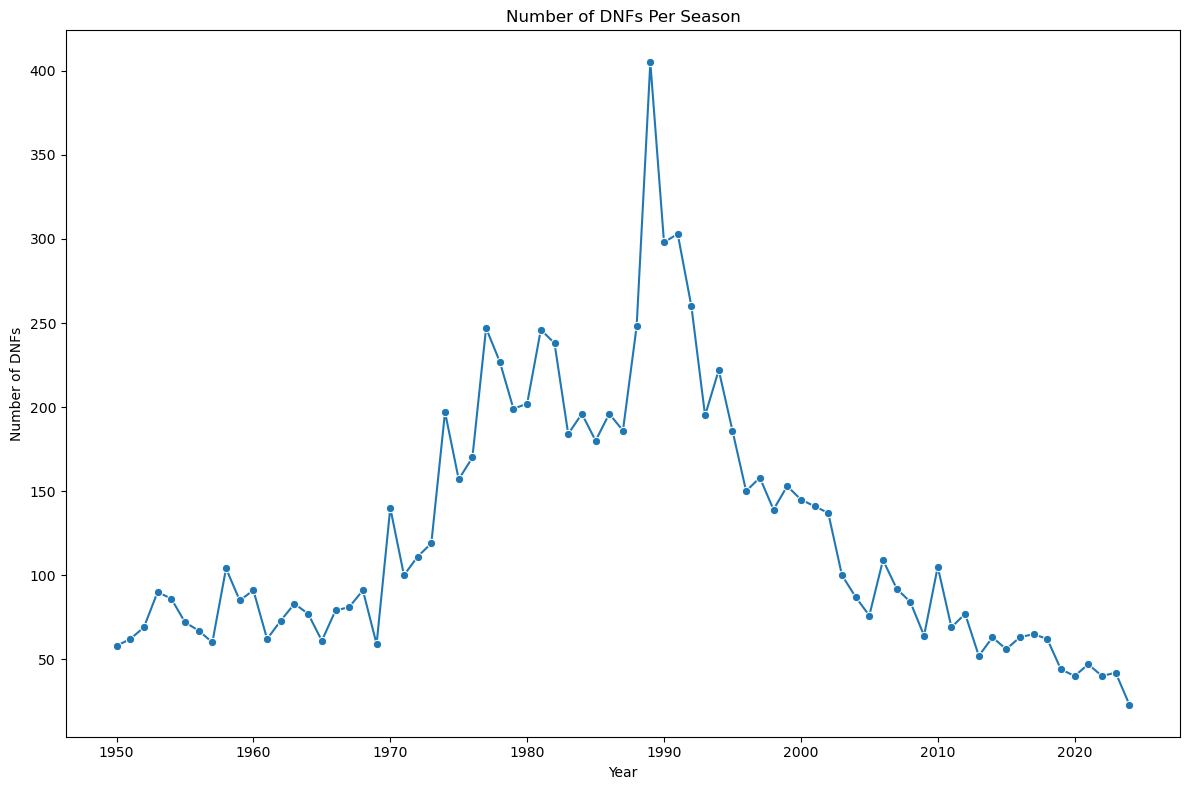

In [96]:
# List of statusId for DNF-related statuses
dnf_status_ids = [
    3, 4, 5, 6, 7, 8, 9, 10, 20, 21, 22, 23, 24, 25, 26, 29, 30, 31, 32, 39, 56, 57, 60, 62, 
    64, 66, 73, 81, 82, 85, 89, 90, 96, 97, 104, 138, 139
]

# 1. Filter results for DNFs based on statusId
dnf_results = results[results['statusId'].isin(dnf_status_ids)]

# 2. Merge with 'races' to get the year of the race
merged_dnf_data = pd.merge(dnf_results, races[['raceId', 'date']], on='raceId')

# 3. Add year from date
merged_dnf_data['year'] = pd.to_datetime(merged_dnf_data['date']).dt.year

# 4. Count DNFs per year (season)
dnfs_per_season = merged_dnf_data.groupby('year').size().reset_index(name='DNFs')

# 5. Plot DNFs per season
plt.figure(figsize=(12, 8))
sns.lineplot(x='year', y='DNFs', data=dnfs_per_season, marker='o')
plt.title("Number of DNFs Per Season")
plt.xlabel('Year')
plt.ylabel('Number of DNFs')
plt.tight_layout()
plt.show()
